In [1]:
import cv2 as cv
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from collections import namedtuple

Extrema = namedtuple('Extrema', ['pyr_idx', 'scale_idx', 'row', 'col'])

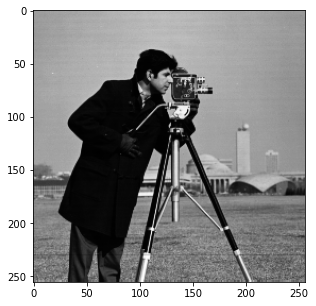

In [2]:
img = plt.imread('Cameraman.png')
# img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
plt.figure(figsize=(5, 5))
plt.imshow(img, 'gray')
plt.show()

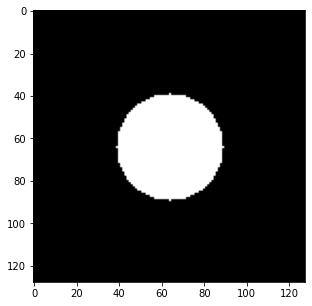

In [3]:
size = 128
imgO = np.zeros((size, size), dtype=np.uint8)
r = size // 5
for i in range(len(imgO)):
    for j in range(len(imgO[0])):
        dst = np.sqrt((size/2 - i)**2 + (size/2 - j)**2)
        if dst <= r:
            imgO[i][j] = 255
plt.figure(figsize=(5, 5))
plt.imshow(imgO, 'gray')
plt.show()

# Build Difference of Gaussian Pyramid

In [4]:
def build_octave_level(img, scales_per_octave, sigmas):
    blurred_imgs = [img]
    for i in range(1, scales_per_octave + 3):
        b_img = cv.GaussianBlur(blurred_imgs[i - 1], (0, 0), sigmas[i])
        blurred_imgs.append(b_img)
    return blurred_imgs


def build_dog_pyramid(img, scales_per_octave=3, sigma=1.6):
    num_octaves = int(np.log2(np.min(img.shape)) - 5) + 1
    k = np.power(2, 1 / scales_per_octave)
    sigmas = [sigma]
    for i in range(1, scales_per_octave + 3):
        sigma_prev = k**(i - 1) * sigma
        sigma_next = k * sigma_prev
        sigmas.append(np.sqrt(sigma_next**2 - sigma_prev**2))
        
    pyramid = list()
    for i in range(num_octaves):
        blurred_imgs = build_octave_level(img, scales_per_octave, sigmas)
        pyramid.append(np.diff(blurred_imgs, axis=0))
        img = blurred_imgs[-3]
        img = img[::2, ::2]
    return pyramid

def plot_pyramid(pyramid, sigma):
    octaves = len(pyramid)
    scales = len(pyramid[0])
    fig, axs = plt.subplots(octaves, scales, figsize=(3 * scales, 3 * octaves))
    for i, octave in enumerate(pyramid):
        for j, dog_img in enumerate(pyramid[i]):
            sig = sigma * 2**(j / (scales - 1))
            axs[i, j].imshow(dog_img, 'gray')
            axs[i, j].set_title(f'Size={dog_img.shape}\nScale={sig:.2f}')
            axs[i, j].axis('off')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
        sigma = sig
    fig.subplots_adjust(wspace=0, hspace=.25)

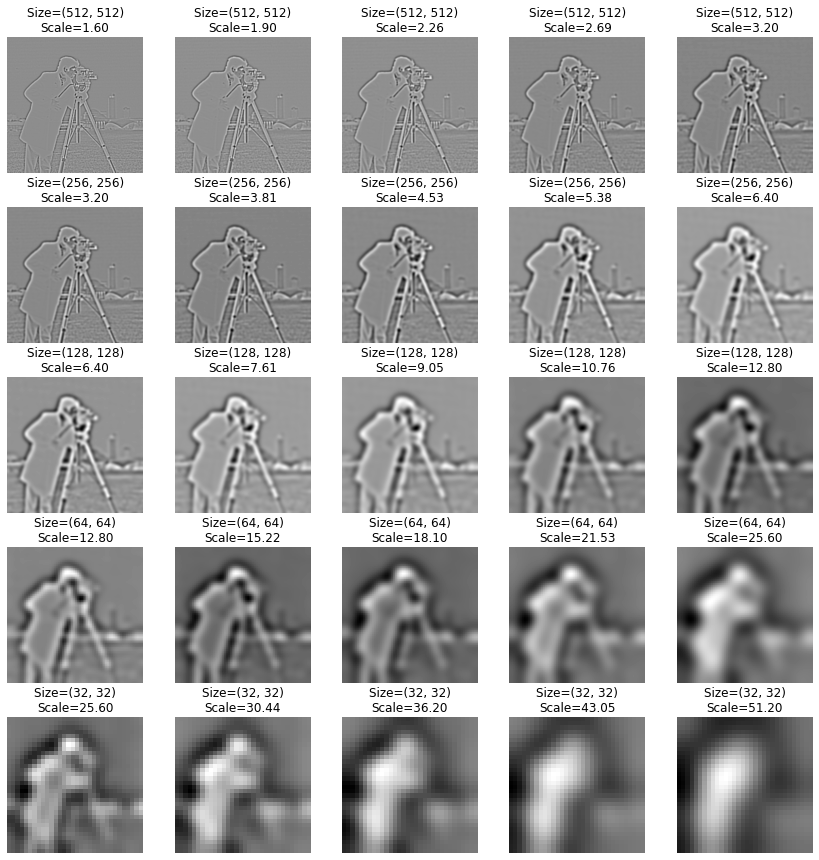

In [5]:
# Assume the original image has a blur of .5, and that therefore 
# the doubled image has sigma = 1.0 relative to its new pixel spacing (Lowe, 2004).
sigma = 1.6

base_img = cv.resize(img, (img.shape[0]*2, img.shape[1]*2), interpolation=cv.INTER_LINEAR)
base_img = cv.GaussianBlur(base_img, (0, 0), np.sqrt(sigma**2 - 0.5**2))

pyramid = build_dog_pyramid(base_img, scales_per_octave=3, sigma=sigma)
plot_pyramid(pyramid, sigma)

# Local Extrema Detection

In [12]:
def local_extrema_detection(pyramid):
    # modified from https://github.com/chcomin/disciplina-visao-computacional-01-2019
    pyr_extremas = list()
    for pidx, octave in enumerate(pyramid):
        for sidx in range(1, len(octave) - 1):
            for r in range(1, octave.shape[1] - 1):
                for c in range(1, octave.shape[2] - 1):
                    patch = octave[sidx-1:sidx+2, r-1:r+2, c-1:c+2].flatten()
                    pixel_value = patch[13]

                    is_max, is_min = True, False
                    for i in range(len(patch)):
                        if pixel_value < patch[i] and i != 13:
                            is_max = False
                            break
                    if not is_max:
                        is_min = True
                        for i in range(len(patch)):
                            if pixel_value > patch[i] and i != 13:
                                is_min = False
                                break
                    if is_max or is_min:
                        pyr_extremas.append(Extrema(pidx, sidx, r, c))
    return pyr_extremas

In [17]:
extremas = local_extrema_detection(pyramid)
len(extremas)

1428

In [ ]:
2*

# Accurate Keypoint Localization

In [181]:
def calculate_hessian(patch):
    i, r, c = 1, 1, 1
    f2 = 2 * patch[i, r, c]
    
    dxx = patch[i, r, c+1] + patch[i, r, c-1] - 2*f2
    dyy = patch[i, r+1, c] + patch[i, r-1, c] - 2*f2
    dss = patch[i+1, r, c] + patch[i-1, r, c] - 2*f2

    dxy = patch[i, r+1, c+1] - patch[i, r+1, c-1] - \
          patch[i, r-1, c+1] + patch[i, r-1, c-1]

    dxs = patch[i+1, r, c+1] - patch[i+1, r, c-1] - \
          patch[i-1, r, c+1] + patch[i-1, r, c-1]

    dys = patch[i+1, r+1, c] - patch[i+1, r-1, c] - \
          patch[i-1, r+1, c] + patch[i-1, r-1, c]

    H = [[dxx, dxy, dxs],
         [dxy, dyy, dys],
         [dxs, dys, dss]]
    return H

def calculate_gradient(patch):
    i, r, c = 1, 1, 1
    
    dx = patch[i, r, c+1] - patch[i, r, c-1]
    dy = patch[i, r+1, c] - patch[i, r-1, c]
    ds = patch[i+1, r, c] - patch[i-1, r, c]

    dD = np.array([dx, dy, ds])
    return dD

def accurate_keypoint_localization(patch, threshold=0.03):
    i, r, c = 1, 1, 1
    H = calculate_hessian(patch)
    H_inv = np.linalg.inv(H)
    dD = calculate_gradient(patch)

    x_hat = -np.dot(H_inv, dD)
    dx_hat = patch[i, r, c] + np.dot(dD.transpose(), x_hat) * 1/2
    if abs(dx_hat) < threshold:
        return False
    return True

In [174]:
ep = extremas[0]
ep

Extrema(pyr_idx=0, scale_idx=1, row=3, col=81)

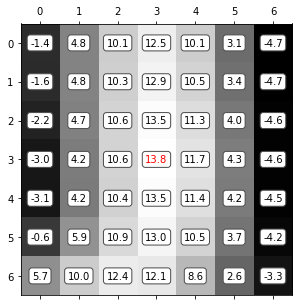

In [175]:
imgp = pyramid[ep.pyr_idx][ep.scale_idx, ep.row-3:ep.row+4, ep.col-3:ep.col+4]
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(imgp, cmap='gray')
for (i, j), z in np.ndenumerate(imgp):
    color = 'black'
    if i == 3 and j == 3:
        color = 'red'
    ax.text(j, i, f'{z*10000:0.1f}', ha='center', va='center', color=color,
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
    )
plt.show()

In [180]:
patch = pyramid[ep.pyr_idx][ep.scale_idx-1:ep.scale_idx+2, ep.row-1:ep.row+2, ep.col-1:ep.col+2]
accurate_keypoint_localization(patch)

0.0013811741309784583


False